# Занятие №10
# Работа с временными рядами


#### План занятия. 
1. Работа с временными данными. Разложение временных рядов на тренд и сезонность.
2. Авторегрессионный подход к временным рядам.
3. Способы оценки качества решения в задаче регрессии.
4. Предсказание временных рядов с помощью Facebook Prophet.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

matplotlib.rcParams.update({'figure.figsize': (12, 8), 'font.size': 14})

# Dark plots
# plt.style.use('dark_background')

## Работа с временными рядами
* __Последовательности__. Данные – наборы значений, на которых задано отношение порядка. Значения могут быть дискретными (например, ДНК), или же могут принимать значения из непрерывного интервала (временной ряд энергопотребления дата центра). Перестановка значений приводит к потере информации. Нельзя нарушать отношение порядка (тестирование на прошлом, обучение на будущем).

Временные ряды – последовательности по своей природе. Как правило, каждый отдельный отсчет – действительное число (или набор чисел, если отслеживается сразу несколько показателей).

В большинстве случаев частота семплирования временного ряда фиксирована (временной промежуток между соседними отсчетами не меняется). В случаях, когда частота семплирования не является постоянной, требуются дополнительные шаги по предобработке данных (или же адаптация модели под новую природу данных).


In [18]:
import pandas as pd

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [20]:
len(df)

2905

Рассмотрим временной ряд, показывающий количество обращений к определенной веб-странице с частотой раз в сутки. Доступны данные с 2008 по 2016 год, т.е. 2905 наблюдений.

In [21]:
time_series = pd.Series(data=df['y'].values, index=pd.to_datetime(df['ds'].values))
time_series = time_series.asfreq(freq='D', method='pad')

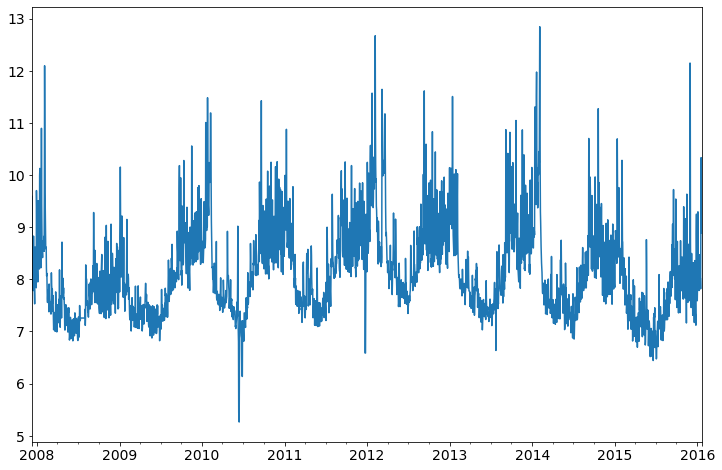

In [22]:
time_series.plot()

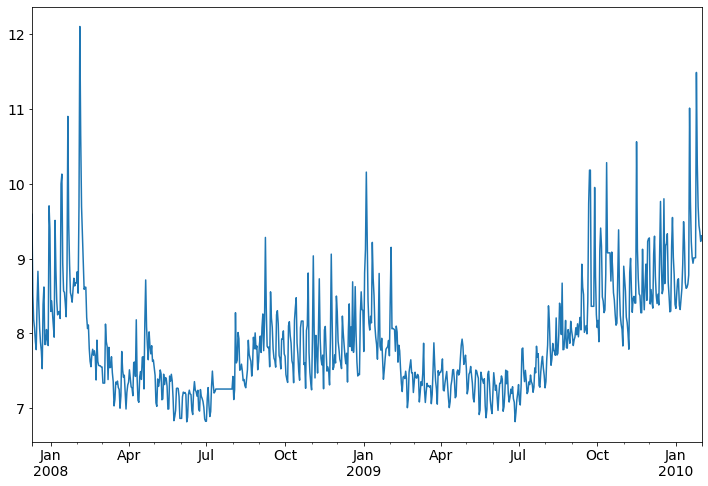

In [23]:
time_series[:7*112].plot()

Наблюдается недельная периодичность и сезонность (весна-лето и осень-зима прослеживаются невооруженным взглядов).

Также полезно бывает разложить временной ряд на тренд и сезонность. Тренд показывет изменение среднего значения с течением времени, сезонность – периодичные изменения.

*Комментарий: стоит помнить, что в данных часто бывает несколько периодичностей (например, суточная, недельная и сезонная для данных об энергопотреблении). В данном случае рассматривается лишь периодичность с наименьшим периодом – недельная).*

In [24]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

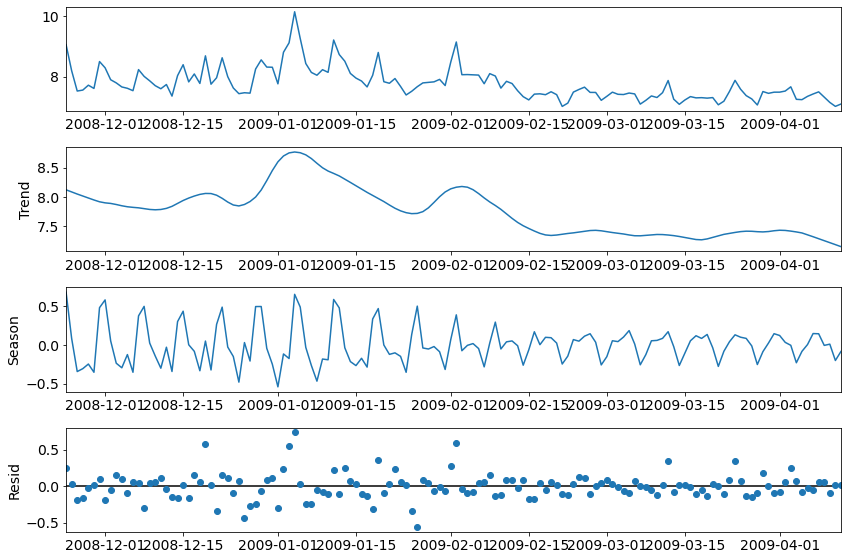

In [25]:
stl = STL(time_series[7*50:7*70])
res = stl.fit()
fig = res.plot()

На графике выше можно наблюдать исходный временной ряд и три компоненты: тренд, сезонность и ошибку – компоненту, которая показывает ошибку восстановления значения временного ряда с помощью двух предыдущих компонент.

Многие методы прогнозирования временных рядов опираются на статистические методы. Например, ARIMA (AutoRegressive Integrated Moving Average). Данная модель показывает достаточно качественные результаты, но ее точная настройка требует серьезной подготовки и ручного анализа.

При прогнозировании временных рядов необходимо предсказать значение временного ряда в определенный момент в будущем. В случае числовых значений, это задача регрессии.

__Задача регрессии__ – задача обучения с учителем, где целевая переменная является континуальным числом (т.е. принимает континуальное число значений). Например, предсказание ожидаемой зарплаты на основе резюме соискателя. Или же предсказание потребления электроэнергии домохозяйством на основании исторических данных.

In [26]:
import numpy as np

In [27]:
forecast_horizon = 28

In [28]:
ts_train_slice = slice(7*215,7*250)

ts_full_slice = slice(ts_train_slice.start, ts_train_slice.stop + forecast_horizon)

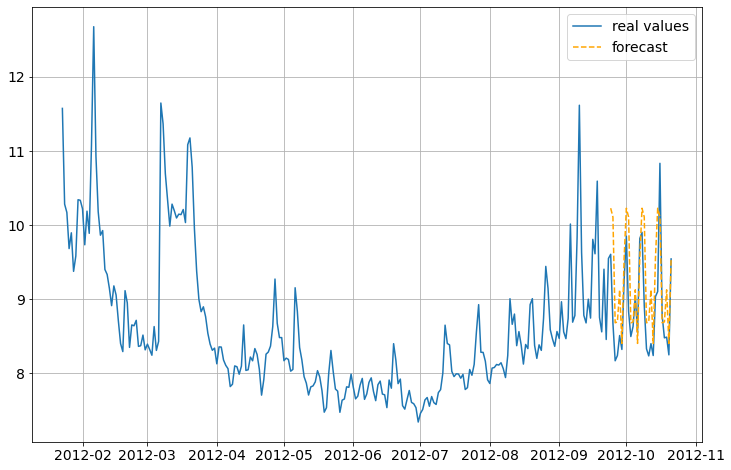

In [29]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

stlf = STLForecast(time_series[ts_train_slice], ARIMA, model_kwargs=dict(order=(1,1,0)))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(forecast_horizon)
plt.plot(time_series[ts_full_slice], label='real values')
plt.plot(forecast, label='forecast', color='orange', linestyle='--')
plt.legend()
plt.grid()
plt.show()

Для оценки качества прогноза стоит воспользоваться подходящими мерами качества. Обратимся к ним далее.

## Обзор основных мер качества в задаче регрессии
Как и в задаче классификации (и во всех других задачах) полученные результаты должны рассматриваться в контексте решаемой бизнес-задачи. Во многих случаях необходимо не только построить точную модель, но и сделать это в адекватные сроки, добиться высокой интерпретируемости результатов или иметь возможность дообучения модели на новых данных.

Далее рассмотрим основные способы оценки качества в задачах регрессии. 

__Mean Squared Error, MSE__ – среднеквадратичная ошибка. Представляет собой среднее значение квадрата отклонения предсказаний от истинных значений целевой переменной. Сильно реагирует на наличие выбросов в данных. В случаях, когда данные не слишком зашумленные, является одной из основных функций ошибки, используемых в задаче регрессии.
$$
\text{MSE}(f(\mathbf{X}), \mathbf{y}) = \frac{1}{N}\sum_{i=1}^{N} (f(\mathbf{x}_i) - y_i)^2
$$

__Mean Absolute Error, MAE__ – среднеабсолютная ошибка. Представляет собой среднее значение модуля отклонения предсказаний от истинных значений целевой переменной. Является значительно более устойчивой к выбросам. Часто используется наряду c MSE. Несмотря на то, что не является гладкой функцией (производная непрерывна на всем множестве определения функции), может минимизироваться и градиентными методами (как правило, производная в нуле доопределяется нулём).

$$
\text{MAE}(f(\mathbf{X}), \mathbf{y}) = \frac{1}{N}\sum_{i=1}^{N} |f(\mathbf{x}_i) - y_i|
$$

__Mean Absolute Percentage Error, MAPE__ позволяет оценить отклонение прогноза от значения целевой переменной в процентном соотношении. Представляет собой среднее значение отношения модуля отклонения предсказаний от истинных значений целевой переменной к значениям целевой переменной. Является значительно более интерпретируемой функцией ошибки (т.к. сразу видно отклонение от целевой переменной). Чуствительна к значениям целевой переменной. Часто используется для оценки качества модели, при обучении которой использовалась другая функция ошибки (например, MSE).

$$
\text{MAPE}(f(\mathbf{X}), \mathbf{y}) = \frac{1}{N}\sum_{i=1}^{N} |\frac{f(\mathbf{x}_i) - y_i}{y_i}|
$$

__Mean Squared Log Error, MSLE__ – то же, что и MSE, но для логарифма значений целевой переменной. Используется в случае, когда есть наблюдения с большими значениями целевой переменной, не являющиеся выбросами. Например, распределение зарплат в регионе. Стоит помнить, что модель предсказывает логарифм целевой переменной.

$$
\text{MSLE}(f(\mathbf{X}), \mathbf{y}) = \frac{1}{N}\sum_{i=1}^{N} (f(\mathbf{x}_i) - \log y_i)^2
$$



__$R^2$-score, коэффициент детерминации__ – доля дисперсии целевой переменной, объясняемая моделью. Может также рассматриваться как сравнение ошибки регрессионной модели и наивного пресказания целевой переменной в средним значением. В отличие от всех предыдущий мер качества, в наилучшем случае принимает значение $1$ (объяснена вся дисперсия). Не ограничена снизу (т.к. модель может быть и хуже простого среднего значения).

$$
R^2(f(\mathbf{X}, \mathbf{y}) = 1 - \frac{\sum_{i=1}^{N}(y_i - f(\mathbf{x}_i))^2}{\sum_{i=1}^{N}(y_i - \bar{y})^2},
$$
где $\bar{y}$ – среднее значение целевой переменной.

In [30]:
def print_scores(real_values, predictions, title=''):
    print(' '.join([title, 'forecast quality']))
    print('Forecast MSE: {:.3f}'.format(mean_squared_error(real_values, predictions)))
    print('Forecast MAE: {:.3f}'.format(mean_absolute_error(real_values, predictions)))
    print('Forecast r2 score: {:.3f}'.format(r2_score(real_values, predictions)))

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
real_values = time_series[forecast.index].values

In [33]:
print_scores(real_values, forecast.values, 'ARIMA with almost no tunning')

ARIMA with almost no tunning forecast quality
Forecast MSE: 0.366
Forecast MAE: 0.468
Forecast r2 score: 0.123


Видно, что качество прогноза не слишком высокое, но коэффициент детерминации $R^2$ выше нуля. Модель ARIMA требует тщательной настройки параметров под конкретный временной ряд. Обратимся к более простым в использовании методам для построения baseline-решения.

## Авторегрессионный подход к задаче прогнозирования временных рядов

Задача прогнозирования временных рядов (особенно периодических) может рассматриваться и как классическая задача регрессии. В качестве признаков выступают предыдущие отсчеты временного ряда, в качестве целевой переменной – будущие значения. Такой подход называется __авторегрессионным__. Преобразуем временной ряд в матрицу объект-признак.

In [34]:
import numpy as np

In [35]:
period = 7

In [36]:
time_series_part = time_series[ts_train_slice].values

In [37]:
data_matrix = np.zeros((int(len(time_series_part)-period), period))

In [38]:
for i in range(len(time_series_part)-period):
    data_matrix[i] = time_series_part[i:i+period]

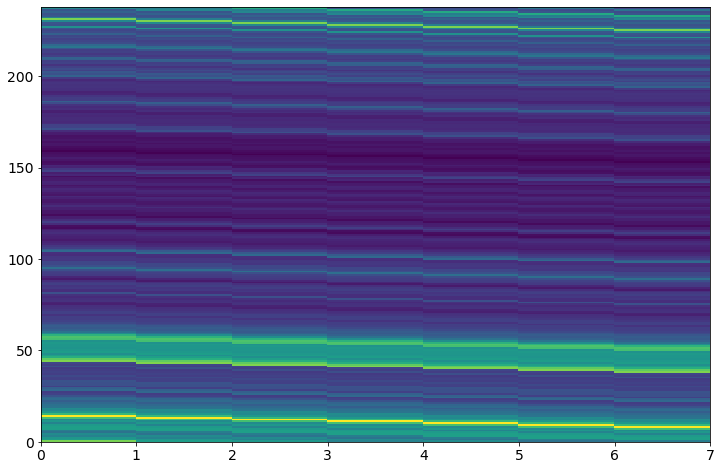

In [39]:
plt.pcolormesh(data_matrix)

In [40]:
from sklearn.linear_model import Lasso

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
data_matrix.shape

(238, 7)

In [43]:
rf = RandomForestRegressor()
rf.fit(data_matrix[-35:, :-1], data_matrix[-35:, -1])

RandomForestRegressor()

In [44]:
curr_repr = list(data_matrix[-1])
for step in range(forecast_horizon):
    next_value = rf.predict(np.asarray(curr_repr)[None, step+1:])
    curr_repr.append(next_value[0])

In [45]:
print_scores(real_values, curr_repr[period:], 'Simple Autoregression with Random Forest')

Simple Autoregression with Random Forest forecast quality
Forecast MSE: 0.453
Forecast MAE: 0.558
Forecast r2 score: -0.086


In [46]:
lr = Lasso()
lr.fit(data_matrix[-25:, :-1], data_matrix[-25:, -1])

Lasso()

In [47]:
curr_repr = list(data_matrix[-1])
for step in range(forecast_horizon):
    next_value = lr.predict(np.asarray(curr_repr)[None, step+1:])
    curr_repr.append(next_value[0])

print_scores(real_values, curr_repr[period:], 'Simple Autoregression with Lasso regression')

Simple Autoregression with Lasso regression forecast quality
Forecast MSE: 0.468
Forecast MAE: 0.590
Forecast r2 score: -0.123


Качество прогноза уступает ARIMA. Но стоит учесть, что при построении прогноза методом авторегресси часто используются техники порождения новых признаков, а также экзогенные переменные (дополнительные данные, не имеющие прямого отношения к временному ряду). Например, информация о погоде при прогнозировании энергопотребления домохозяйств.

## Facebook Prophet в прогнозировании временных рядов
Facebook Prophet – относительно молодая библиотека, отлично подходящая для прогнозирования временных рядов. Отдельно стоит выделить, что данная библиотека значительно упрощает учет различных дополнительных данных (например, календарные праздники, некоторые особые события) и неплохо работает с пропусками в автоматическом режиме. В целом, Prophet является отличным решением для работы с временными рядами во многих бизнес-задачах, и может предоставить качественный baseline (а при точной настроке и хорошее решение для многих задач).

In [48]:
from fbprophet import Prophet

In [49]:
model = Prophet()

In [50]:
# new_slice = slice(None, ts_train_slice.stop)
new_slice = slice(ts_train_slice.stop - 7 * 56 * 2, ts_train_slice.stop)

In [51]:
time_series

2007-12-10     9.590761
2007-12-11     8.519590
2007-12-12     8.183677
2007-12-13     8.072467
2007-12-14     7.893572
                ...    
2016-01-16     7.817223
2016-01-17     9.273878
2016-01-18    10.333775
2016-01-19     9.125871
2016-01-20     8.891374
Freq: D, Length: 2964, dtype: float64

In [52]:
pr_df = pd.DataFrame()
pr_df['ds'] = time_series[new_slice].index
pr_df['y'] = time_series[new_slice].values

In [53]:
model.fit(pr_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
forecast_horizon

28

In [55]:
future = model.make_future_dataframe(periods=forecast_horizon)
future.tail()

,ds
807,2012-10-17
808,2012-10-18
809,2012-10-19
810,2012-10-20
811,2012-10-21


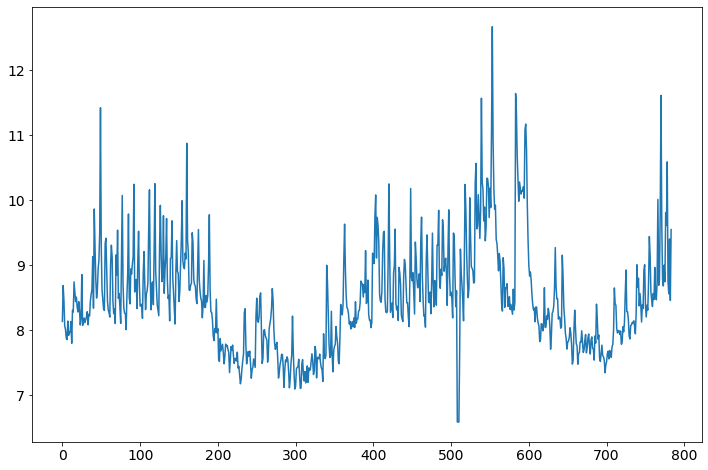

In [56]:
pr_df['y'].plot()

In [57]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
807,2012-10-17,8.575675,7.938737,9.253212
808,2012-10-18,8.592971,7.931475,9.254179
809,2012-10-19,8.616798,7.962234,9.258785
810,2012-10-20,8.442891,7.842730,9.121022
811,2012-10-21,8.830899,8.173489,9.482971


In [58]:
def plot_forecast(real_data, predictions, future_start=None, confidence=None):
    fig, ax = plt.subplots()

    ax.plot(real_data.index, real_data.values, label='real data')
    ax.plot(predictions.index, predictions.values, linestyle='--', color='orange', label='predictions')
    if future_start is not None:
        plt.axvline(future_start)
    if confidence is not None:
        ax.fill_between(predictions.index, confidence[0], confidence[1], color='orange', alpha=0.2)
    plt.legend()


In [59]:
_start = pd.to_datetime(future['ds'].iloc[-forecast_horizon-7*5])

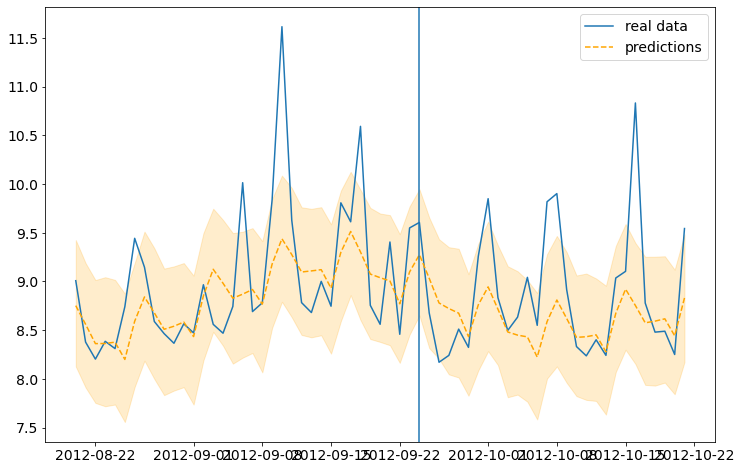

In [60]:
plot_forecast(
    time_series.iloc[new_slice.stop-7*5:new_slice.stop + forecast_horizon],
    pd.Series(index=forecast['ds'].values, data=forecast['yhat'].values).loc[_start:],
    future_start=future['ds'].iloc[-forecast_horizon],
    confidence=(
        pd.Series(index=forecast['ds'].values, data=forecast['yhat_lower'].values).loc[_start:],
        pd.Series(index=forecast['ds'].values, data=forecast['yhat_upper'].values).loc[_start:],
    )
)

In [61]:
print_scores(real_values, forecast['yhat'].iloc[-forecast_horizon:], 'Prophet default forecast')

Prophet default forecast forecast quality
Forecast MSE: 0.372
Forecast MAE: 0.417
Forecast r2 score: 0.107


### Box-Cox преобразование

In [62]:
from scipy import stats

In [63]:
def inv_boxcox(values, lambda_value):
    if lambda_value == 0:
        return np.exp(values)
    else:
        return np.exp(np.log(lambda_value * values + 1) / lambda_value)

In [64]:
normalized_pr_df = pr_df.copy()
normalized_pr_df['y'], lambda_value = stats.boxcox(pr_df['y'])

In [65]:
lambda_value

-2.1812959852382865

In [66]:
new_model = Prophet()
new_model.fit(normalized_pr_df)
normalized_forecast = new_model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [67]:
restored_forecast = normalized_forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].copy()
for column_name in ['yhat_lower', 'yhat_upper', 'yhat']:
    restored_forecast[column_name] = inv_boxcox(restored_forecast[column_name].values, lambda_value)

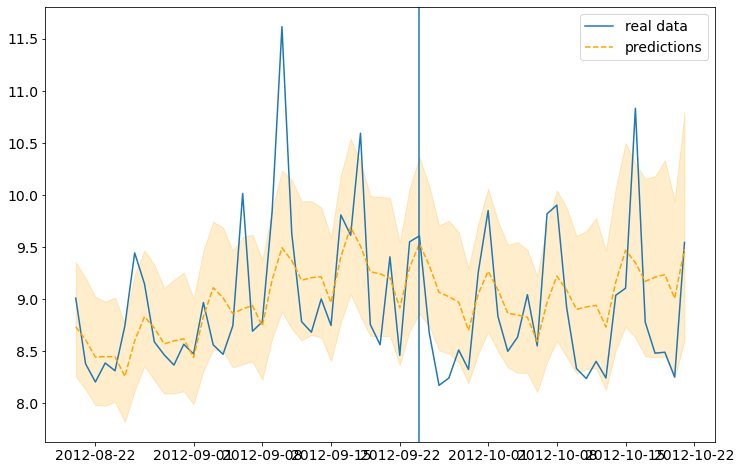

In [68]:
plot_forecast(
    time_series.iloc[new_slice.stop-7*5:new_slice.stop + forecast_horizon],
    pd.Series(index=restored_forecast['ds'].values, data=restored_forecast['yhat'].values).loc[_start:],
    future_start=future['ds'].iloc[-forecast_horizon],
    confidence=(
        pd.Series(index=restored_forecast['ds'].values, data=restored_forecast['yhat_lower'].values).loc[_start:],
        pd.Series(index=restored_forecast['ds'].values, data=restored_forecast['yhat_upper'].values).loc[_start:],
    )
)

In [69]:
print_scores(real_values, restored_forecast['yhat'].iloc[-forecast_horizon:], 'Prophet forecast with Box-Cox transformation')

Prophet forecast with Box-Cox transformation forecast quality
Forecast MSE: 0.342
Forecast MAE: 0.491
Forecast r2 score: 0.181


### Учет дополнительных данных
Одна из сильных сторон Prophet – относительная простота использования дополнительной информации при построении прогноза. Например, информации об особых днях:

In [70]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [71]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
normalized_forecast_with_extra_data = m.fit(normalized_pr_df).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
restored_forecast_with_extra_data = normalized_forecast_with_extra_data.copy()
for column_name in ['yhat_lower', 'yhat_upper', 'yhat']:
    restored_forecast_with_extra_data[column_name] = inv_boxcox(restored_forecast_with_extra_data[column_name].values, lambda_value)

In [73]:
restored_forecast_with_extra_data[(restored_forecast_with_extra_data['playoff'] + restored_forecast_with_extra_data['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']]

,ds,playoff,superbowl
159,2011-01-08,0.000483,0.0
160,2011-01-09,0.001329,0.0


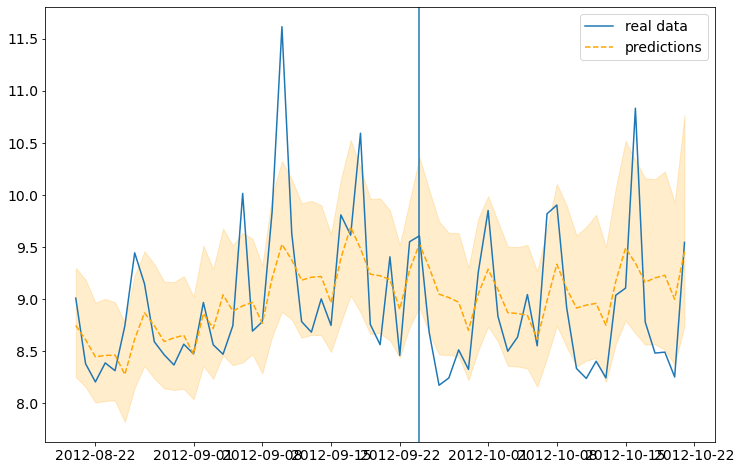

In [74]:
plot_forecast(
    time_series.iloc[new_slice.stop-7*5:new_slice.stop + forecast_horizon],
    pd.Series(index=restored_forecast_with_extra_data['ds'].values, data=restored_forecast_with_extra_data['yhat'].values).loc[_start:],
    future_start=future['ds'].iloc[-forecast_horizon],
    confidence=(
        pd.Series(index=restored_forecast_with_extra_data['ds'].values, data=restored_forecast_with_extra_data['yhat_lower'].values).loc[_start:],
        pd.Series(index=restored_forecast_with_extra_data['ds'].values, data=restored_forecast_with_extra_data['yhat_upper'].values).loc[_start:],
    )
)

In [75]:
print_scores(real_values, restored_forecast_with_extra_data['yhat'].iloc[-forecast_horizon:], 'Prophet forecast with Box-Cox transformation and additional data')

Prophet forecast with Box-Cox transformation and additional data forecast quality
Forecast MSE: 0.335
Forecast MAE: 0.489
Forecast r2 score: 0.197


В библиотеке доступны также и официальные праздники в Российской Федерации.

In [76]:
m_ru = Prophet()
m_ru.add_country_holidays(country_name='RU')
m_ru.fit(pr_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
m_ru.train_holiday_names


0                    New Year's Day
1            Orthodox Christmas Day
2                     Christmas Day
3    Defender of the Fatherland Day
4         International Women's Day
5                 National Flag Day
6             Spring and Labour Day
7                       Victory Day
8                        Russia Day
9                         Unity Day
dtype: object

## Выводы:

* Временные ряды встречаются практически во всех процессах, их анализ может помочь с формулировкой новых гипотез и с проверкой текущих.
* При работе с упорядоченными данными требуется учитывать их структуру и не нарушать их порядок (дабы не допускать "заглядывания" моделью в будущее).
* Статистические методы прогнозирования временных рядов показывают хорошие результаты, но требуют тонкой настройки.
* Временные ряды также преставимы в виде классической матрицы объект-признак.
* Для построения прототипа модели прогнозирования хорошо подходит библиотека Prophet.
* Использование релевантной дополнительной информации (информация о праздниках, экзогенные факторы) положительно сказывается на качестве итоговой модели.